# Problem 1

### Classes to implement k-means

In [6]:
import random

class Point:
  def __init__(self, attrs, id=None, cluster=None):
    self.attrs = attrs
    if id is not None:
      self.id = id
    self.id = -1
    self.cluster = None

  def __getitem__(self, i):
    return self.attrs[i]

  def __getattr__(self, attr):
    if attr == 'x':
      return self.attrs[0]
    elif attr == 'y':
      return self.attrs[1]
    elif attr == 'attrs':
      return self.attrs
    elif attr == 'id':
      return self.id
    elif attr == 'cluster':
      return self.cluster

  def dist_to(self, other):
    the_sum = 0
    for i in range(len(self.attrs)):
      # if (type(self.attrs[i]) is int or type(self.attrs[i]) is float)\
      #     and (type(other.attrs[i] is int or type(other.attrs[i] is float))):
        the_sum += (self.attrs[i] - other.attrs[i]) ** 2
    return the_sum ** 0.5

  def setCluster(self, cluster):
    self.cluster = cluster.id

  def __repr__(self):
    return str(self.attrs)

  @staticmethod
  def _parseNum(num):
    split = num.split('E')
    return float(split[0]) * 10 ** int(split[1])

  @staticmethod
  def parseCoord(coord):
    x = Point._parseNum(coord[0])
    y = Point._parseNum(coord[1])

    return [x, y]
  
  def __eq__(self, other):
    if len(self.attrs) != len(other.attrs):
      return False
    
    for i in range(len(self.attrs)):
      if (type(self.attrs[i]) is int or type(self.attrs[i]) is float)\
          and (type(other.attrs[i] is int or type(other.attrs[i] is float))):
          if self.attrs[i] != other.attrs[i]:
            return False

    return True

  
  def __ne__(self, other):
    return not self == other


class Cluster:
  def __init__(self, center, id, points=None):
    self.center = center
    if points is not None:
      self.points = points
    else:
      self.points = []

    self.id = id
  def reCalcCenter(self):
    if len(self.points) == 0:
      return
    var_sum = [0 for _ in self.center.attrs]

    for p in self.points:
      for i in range(len(p.attrs)):
        var_sum[i] += p[i]
    
    new_attrs = [var_sum[i] / len(self.points) for i in range(len(self.center.attrs))]

    self.center = Point(new_attrs)
  
  def clear(self):
    self.points.clear()

  def addPoint(self, point):
    self.points.append(point)
  
  def remPoint(self, point):
    for i, p in enumerate(self.points):
      if p == point:
        del self.points[i]
        return True
    return False

  def __repr__(self):
    return str(self.center)


def getMinMax(points):
  minMax = [[None, None] for _ in range(len(points[0].attrs))]

  for p in points:
    for i, a in enumerate(p.attrs):
      if minMax[i][0] is not None and a < minMax[i][0]:
        minMax[i][0] = a
      elif minMax[i][0] is None:
        minMax[i][0] = a

      if minMax[i][1] is not None and minMax[i][1] < a:
        minMax[i][1] = a
      elif minMax[i][1] is None:
        minMax[i][1] = a
      
  return minMax


## Visualization

In [7]:
from PIL import Image, ImageDraw, ImageFont

def plot_points(points, fill='blue', image=None, pRange=None, label=None, axis=False):
    if pRange is None:
      minX = min([p.x for p in points])
      maxX = max([p.x for p in points])
      minY = min([p.y for p in points])
      maxY = max([p.y for p in points])

    else:
      minX = pRange[0]
      maxX = pRange[1]
      minY = pRange[2]
      maxY = pRange[3]

    size = 800
    xRange = max(maxX - minX, 0.01)
    yRange = max(maxY - minY, 0.01)

    padding = [20, 20, 20, 20] # top, right, bottom, left
    if axis:
      padding = [70, 10, 10, 70]

    axisSize = [45, 65] # [x axis height, y axis width]
    
    xExp = (size - (padding[1] + padding[3])) / xRange
    yExp = (size - (padding[0] + padding[2])) / yRange

    offsetX = padding[3]
    offsetY = padding[0]

    for p in points:
      p.x -= minX
      p.y -= minY
    
    radius = 5
    if image is None:
        image = Image.new("RGB", (size, size))
   
    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype('arial.ttf', 20)
    if label is not None:
      draw.text((offsetX + xExp * points[0].x - 30, offsetY + yExp * points[0].y + 15), label, fill=fill, font=font)


    if axis:
      ## Axis lines
      # X Axis
      draw.line(((axisSize[1], axisSize[0]), (axisSize[1], size)), fill='white', width=5)
      draw.line(((axisSize[1], axisSize[0]), (size, axisSize[0])), fill='white', width=5)
      for i in range(axisSize[0], 801, 100):
        ## X Axis Labels and Ticks
        if i == axisSize[0]:
          continue
        draw.line(((i, axisSize[0]), (i, axisSize[0] + 5)), fill='white')
        draw.text((i - 22, axisSize[0] - 22), "{:.3f}".format((i - axisSize[0]) / xExp), font=font)

      
      for i in range(axisSize[1], 801, 100):
        ## Y Axis Label and Ticks
        draw.line(((axisSize[1], i), (axisSize[1], i)), fill='white')
        draw.text((1, i - 10), "{:.3f}".format((i - axisSize[1]) / yExp), font=font)

      # Axis Labels
      draw.text((0, size - 20), 'Length', font=font)
      draw.text((size - 70, axisSize[0] - 40), "Width", font=font)
  
    for p in points:
        draw.ellipse((offsetX + xExp * p.x - radius,
                      offsetY + yExp * p.y - radius,
                      offsetX + xExp * p.x + radius,
                      offsetY + yExp * p.y + radius), fill=fill)

    return image, [minX, maxX, minY, maxY]


## K-Means

In [8]:
def kmeans(points, num_clusters, plot=False):
  """
  Group points into n clusters (num_clusters) using k-means
  points: Points to be clustered
  num_clusters: Number of clusters
  plot: If true will plot the clusters after every iteration, false will do nothing
  """
  minMax = getMinMax(points)
  clusters = []

  for i in range(num_clusters):
    attrs = []
    for key in range(len(points[0].attrs)):
      # attrs.append(0)
      attrs.append(random.uniform(minMax[key][0], minMax[key][1]))

    clusters.append(Cluster(Point(attrs), i))

  while True:
    for p in points:
      min_dist = None
      min_clust_index = None
      for i, c in enumerate(clusters):
        dist = p.dist_to(c.center)

        if min_dist is None or dist < min_dist:
          min_dist = dist
          min_clust_index = i
      clusters[min_clust_index].addPoint(p)


    
    if plot:
      img = plot_points([Point(-100, -100)])
      colors = ['red', 'blue', 'yellow']
    anyChange = False
    for i, c in enumerate(clusters):
      oldCenter = c.center
      c.reCalcCenter()
      if oldCenter != c.center:
        anyChange = True

      if plot:
        img = plot_points(c.points, fill=colors[i], image=img)
        img = plot_points([c.center], fill='green', image=img)

  
    if plot:
      img.show()
      input() # Pauses after each step


    
    if not anyChange:
      break
    else:
      [c.clear() for c in clusters]

  return clusters

def predict(clusters, example):
 
  min_dist = None
  min_clust_index = None
  for i, c in enumerate(clusters):
    dist = example.dist_to(c.center)

    if min_dist is None or dist < min_dist:
      min_dist = dist
      min_clust_index = i
  
  return min_clust_index


## Run K-Means on cluster_data.txt and display results

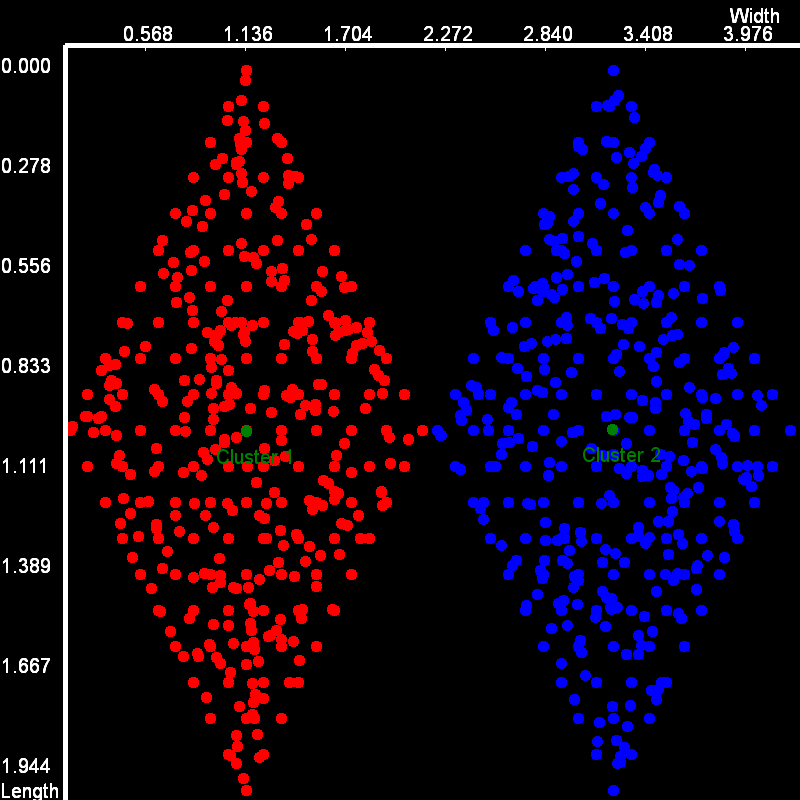

In [12]:
def getPointsFromFile(file):

  with open(file, 'r') as theFile:
    points = []
    split = theFile.read().split('\n') 
    for line in split:
      if line != '':
        point_split = line.split('\t')
        point = Point(Point.parseCoord(point_split[1:]), int(point_split[0]))
        points.append(point)
    return points


points = getPointsFromFile('cluster_data.txt') # Loads points from Fil
# Points are in format [Point(x,y), Point(x,y), ..., Point(x,y)]
# Where Point is a point object defined at the top of the file\
minX = min([p.x for p in points])
maxX = max([p.x for p in points])
minY = min([p.y for p in points])
maxY = max([p.y for p in points])
pRange = [minX, maxX, minY, maxY] # Gets maximum and minimum values to plot effectively
clusters = kmeans(points, 2) # Runs K-Means


## Code below used to plot data on an image and display it. 
img, _ = plot_points([Point([-100 for _ in points[0].attrs])], fill='black') # Creates empty image, just leave this code

colors = ['red', 'blue', 'white', 'purple', 'orange', 'navy'] # Available colors for clusters
for i, c in enumerate(clusters):
    # Plots individual points from the cluster
    img, _ = plot_points(c.points, fill=colors[i], image=img, pRange=pRange, axis=True) 
    # Plots the clusters centers and labels them
    img, _ = plot_points([c.center], fill='green', image=img, pRange=pRange, 
                         label='Cluster ' + str(i + 1), axis=True)


display(img) # Displays image in output

## Findings Explanation
Based on the visualization it it appears there are two clusters. When k-means is set to 2 it clusters the data properly. 

# Problem 2

## Logistic Regression Implementation

In [14]:
import numpy as np 
from math import e


def sigmoid(z):
  return (1.0 / (1.0 + e ** -z))

class LogisticRegression:

  def predict(self, X):
    z = np.dot(X, self.w)
    return (1.0 / (1.0 + e ** -z)) ## Sigmoid

  
  def fit(self, X, y, alpha=500, lam_bda=1, cycles=1000000):

    self.w = np.zeros(len(X[0]))
    self.m = len(X)
    self.n = len(X[0])

    for _ in range(cycles):
    
      predictions = self.predict(X)

      gradient = np.dot(X.T, predictions - y) + (lam_bda / self.m) * sum(self.w)

      gradient = gradient * (alpha / self.m)

      self.w -= gradient



### Results

#### For un-normalized data the variance was too large and logistic regression was not able to converge on answer.

#### For normalized data here are the results with varying lambda.
[[-2.0, nan], 
[-1.8, 0.7394209354120267], [-1.6, 0.7394209354120267], [-1.4000000000000001, 0.7394209354120267], [-1.2000000000000002, 0.7394209354120267], [-1.0000000000000002, 0.7387387387387387], [-0.8000000000000003, 0.7540983606557379], [-0.6000000000000003, 0.7733990147783252], [-0.40000000000000036, 0.8206521739130433], [-0.2000000000000004, 0.8459214501510574], [-4.440892098500626e-16, 0.8698412698412699], [0.1999999999999993, 0.8698412698412699], [0.39999999999999947, 0.8698412698412699], [0.5999999999999996, 0.8698412698412699], [0.7999999999999994, 0.8698412698412699], [0.9999999999999991, 0.8698412698412699], [1.1999999999999993, 0.8698412698412699], [1.3999999999999995, 0.8698412698412699], [1.5999999999999992, 0.8698412698412699], [1.799999999999999, 0.8698412698412699], [1.9999999999999991, 0.8698412698412699], [2.1999999999999993, 0.8698412698412699], [2.3999999999999986, 0.8698412698412699], [2.5999999999999988, 0.8698412698412699], [2.799999999999999, 0.8698412698412699], [2.999999999999999, 0.8698412698412699], [3.1999999999999993, 0.8698412698412699], [3.3999999999999986, 0.8698412698412699], [3.5999999999999988, 0.8698412698412699], [3.799999999999999, 0.8698412698412699]]
[[-2.0, nan], [-1.8, 0.7321428571428572], [-1.6, 0.7321428571428572], [-1.4000000000000001, 0.7321428571428572], [-1.2000000000000002, 0.7321428571428572], [-1.0000000000000002, 0.7313769751693002], [-0.8000000000000003, 0.7529411764705882], [-0.6000000000000003, 0.7733990147783252], [-0.40000000000000036, 0.8152173913043478], [-0.2000000000000004, 0.8389057750759878], [-4.440892098500626e-16, 0.8525641025641026], [0.1999999999999993, 0.8525641025641026], [0.39999999999999947, 0.8525641025641026], [0.5999999999999996, 0.8525641025641026], [0.7999999999999994, 0.8525641025641026], [0.9999999999999991, 0.8525641025641026], [1.1999999999999993, 0.8525641025641026], [1.3999999999999995, 0.8525641025641026], [1.5999999999999992, 0.8525641025641026], [1.799999999999999, 0.8525641025641026], [1.9999999999999991, 0.8525641025641026], [2.1999999999999993, 0.8525641025641026], [2.3999999999999986, 0.8525641025641026], [2.5999999999999988, 0.8525641025641026], [2.799999999999999, 0.8525641025641026], [2.999999999999999, 0.8525641025641026], [3.1999999999999993, 0.8525641025641026], [3.3999999999999986, 0.8525641025641026], [3.5999999999999988, 0.8525641025641026], [3.799999999999999, 0.8525641025641026]]